# 목적소개:

흔들리는 시장에서 사람은 객관적이고 냉정한 투자를 하지 못하는 경향이 있음.

최근 시장에서는 급등주, 테마주를 따라다니는 것처럼 비효율적인 시장의 움직임을 따라가는 투기가 아닌, 가치투자를 하는 것이 필요하다고 생각함.

현 시장에 나와있는 수 많은 ETF상품이 있지만, *수익성에 대한 보장(검증)은 없는 것*은 물론, 다양하고 여러가지의 비정량화된 섹터로만 묶여있음.

이러한 시장에서 우리 팀은 계량적이며 확률론적인 통계기법을 사용하여 산출된 지표를 통해 투자하는 것(퀀트)과 인간이 할 수 없는 수많은 조합들을 비교하고 골라내는 것을 활용하여(머신러닝) 객관적이고 의미있는 투자를 하자는 목적으로 설계함

#### 한마디로, 머신러닝과 퀀트의 조합으로 분기별 최적의 종목들을 선별하고 구매 비율까지 조정한 완벽한 주식 포트폴리오 구성하는 목적!!

# 사용데이터:
최근 3년동안의 KRX 전종목 데이터 및 기본제무 정보

# Process:
### 1. 투자시점으로부터 최근 3년동안의 종목 일별 데이터 수집 (*수집한 데이터를 SQLite DB 형태로 저장하였고, 본 노트북에서는 DB 의 일별데이터를 가져와서 분석하는 방식으로 진행*)
### 2. 각 기간별(y-3, y-2, y-1) 1년치 데이터를 기반으로 K-Mean알고리즘을 통한 종목 군집화 (변동성과 수익성을 고려)
### 3. 각 기간별 선택된 군집에서 교집합되는 종목을 선정하고, 각 종목별 벨류지표를 기반으로 한 랭킹시스템을 통해 최종 투자 종목 리스트(포트폴리오)를 산정 (벨류지표: PER, PBR, EPS, DIV, DPS)
### 4. 몬테카를로 시뮬레이션을 통해 포트폴리오의 최적인 투자예산 배분 (리스크 or 샤프지수)
### 5. 구매 시점에서 구성된 포트폴리오의 연간수익률을 백테스팅으로 검증

필요한 라이브러리 import

In [114]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#Import Model Packages
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import cluster, metrics
from pykrx import stock
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings(action='ignore')

## 1) 2018년도 (y-3) KOSPI, KOSDAQ 모든 종목의 일별 데이터 추출
k-mean_1st_year : 2018 년 데이터

In [115]:
conn_1st_year = sqlite3.connect('dacon-stock.db')
df_1st_year = pd.read_sql_query("SELECT * FROM tb_krx_daily WHERE Date >= '2018-01-01' and Date < '2019-01-01';", conn_1st_year)
dataset_1st_year = df_1st_year.set_index(["Date","Code"])[["Close"]].unstack()
dataset_1st_year.head(10)

Close                                               \
Code                  000020  000040   000050   000060    000070   000075   
Date                                                                        
2018-01-02 00:00:00   9870.0  1985.0  13850.0  23350.0  121500.0  55800.0   
2018-01-03 00:00:00  10000.0  1985.0  13750.0  23350.0  123500.0  56100.0   
2018-01-04 00:00:00   9750.0  1985.0  13750.0  22700.0  122000.0  55800.0   
2018-01-05 00:00:00   9910.0  1985.0  13550.0  23250.0  129500.0  56600.0   
2018-01-08 00:00:00   9950.0  1985.0  13450.0  23000.0  129000.0  57000.0   
2018-01-09 00:00:00   9770.0  1985.0  13600.0  23150.0  128500.0  57300.0   
2018-01-10 00:00:00   9840.0  1985.0  13600.0  22850.0  129000.0  57400.0   
2018-01-11 00:00:00  10300.0  1985.0  13750.0  23600.0  125000.0  57400.0   
2018-01-12 00:00:00  10250.0  2578.0  13900.0  23650.0  127000.0  57400.0   
2018-01-15 00:00:00  10350.0  2627.0  14100.0  24450.0  125500.0  57100.0   

                                                         ...                  \
Code                  000080   000087   000100   000105  ...  900280  900290   
Date                                                     ...                   
2018-01-02 00:00:00  24400.0  18250.0  36410.0  30395.0  ...  1404.0  5457.0   
2018-01-03 00:00:00  24800.0  18350.0  36159.0  30643.0  ...  1411.0  5450.0   
2018-01-04 00:00:00  24550.0  18200.0  35655.0  31472.0  ...  1307.0  5418.0   
2018-01-05 00:00:00  24400.0  18300.0  36494.0  30892.0  ...  1295.0  5323.0   
2018-01-08 00:00:00  23850.0  18200.0  36075.0  30560.0  ...  1246.0  5284.0   
2018-01-09 00:00:00  24500.0  18250.0  36998.0  31057.0  ...  1269.0  5252.0   
2018-01-10 00:00:00  24800.0  18150.0  36745.0  30643.0  ...  1324.0  5355.0   
2018-01-11 00:00:00  24900.0  18150.0  36830.0  30395.0  ...  1608.0  5418.0   
2018-01-12 00:00:00  24500.0  18050.0  38088.0  31140.0  ...  1608.0  5379.0   
2018-01-15 00:00:00  22900.0  17950.0  38171.0  31803.0  ...  1630.0  5331.0   

                                                                             \
Code                 900300  900310 900340  950110  950130  950140   950160   
Date                                                                          
2018-01-02 00:00:00  3040.0  3185.0    NaN  7730.0  4695.0  6160.0  54300.0   
2018-01-03 00:00:00  3115.0  3255.0    NaN  7670.0  4770.0  6080.0  53800.0   
2018-01-04 00:00:00  3105.0  3135.0    NaN  8200.0  4650.0  6010.0  53100.0   
2018-01-05 00:00:00  3165.0  3070.0    NaN  8400.0  4640.0  6000.0  54000.0   
2018-01-08 00:00:00  3150.0  3015.0    NaN  8780.0  4540.0  5940.0  56200.0   
2018-01-09 00:00:00  3065.0  3095.0    NaN  8310.0  4675.0  5880.0  55300.0   
2018-01-10 00:00:00  3165.0  3305.0    NaN  8310.0  4700.0  5970.0  53500.0   
2018-01-11 00:00:00  3105.0  3230.0    NaN  8240.0  4835.0  6000.0  53000.0   
2018-01-12 00:00:00  3015.0  3175.0    NaN  8340.0  4810.0  5880.0  53700.0   
2018-01-15 00:00:00  2980.0  3175.0    NaN  8900.0  5250.0  5920.0  56200.0   

                            
Code                950170  
Date                        
2018-01-02 00:00:00    NaN  
2018-01-03 00:00:00    NaN  
2018-01-04 00:00:00    NaN  
2018-01-05 00:00:00    NaN  
2018-01-08 00:00:00    NaN  
2018-01-09 00:00:00    NaN  
2018-01-10 00:00:00    NaN  
2018-01-11 00:00:00    NaN  
2018-01-12 00:00:00    NaN  
2018-01-15 00:00:00    NaN  

[10 rows x 2143 columns]

## 2. K-Mean을 통한 종목 군집화(변동성과 수익성을 고려), (과거 동일 분기 및 최근 트랜드 반영)

#### 2022년 1분기에 투자할 종목을 선정하기 위해 최근 3년 (19,20,21년도) 1분기에서 가장 움직임이 유사(변동성과 수익성)한 군집을 추출하는 과정

#### K-Mean 활용 이유?
→ 수익률(return)과 변동성(volatility)이 같은 그룹으로 클러스터링

→ 2500개가 넘는 다양한 종목에서 비슷한 섹터의 종목, 혹은 익숙한 종목(잘 알려진)을 경향을 선택하고 투자하는 경향이 많음

→ 수익과 변동성을 가지고 클러스터링을 하게 되면 동일한 움직임을 가져가는 종목군집을 새롭게 만들 수 있음

#### 과거 동일 분기 클러스터 (최근 3년치)

    ex)A = 2018
       B = 2019
       C = 2020
    (흡사 모멘텀 전략과 비슷)

각 그룹(A, B, C) 에서 변동성이 가장 적고 수익이 상승하는 군집 각 선택

→ 각 클러스터에 해당하는 종목의 기울기 평균

→ $A_n, B_n, C_n$

선택된 군집에서 공통적으로 존재하는 종목을 선택

→ $A_n \bigcap\ B_n \bigcap\ C_n$


→ 위에서 말한 모든 조건을 만족시키는 새로운 종목 군집이 탄생

데이터의 n/a 값을 확인하고 이를 삭제하거나 열의 평균으로 채운다.

In [116]:
print('Null Values =',dataset_1st_year.isnull().values.any())

Null Values = True


결측치가 30% 이상인 종목을 제거한다

In [117]:
missing_fractions_1st_year = dataset_1st_year.isnull().mean().sort_values(ascending=False)
drop_list_1st_year = sorted(list(missing_fractions_1st_year[missing_fractions_1st_year > 0.3].index))
dataset_1st_year.drop(labels=drop_list_1st_year, axis=1, inplace=True)
dataset_1st_year.shape

(244, 2058)

Null 값이 있는 경우 삭제한다

In [118]:
dataset_1st_year = dataset_1st_year.fillna(method='ffill')

In [119]:
returns_1st_year = pd.DataFrame(dataset_1st_year.pct_change().mean() * len(dataset_1st_year))
returns_1st_year.columns = ['Returns']
returns_1st_year['Volatility'] = dataset_1st_year.pct_change().std() * np.sqrt(len(dataset_1st_year))
data_1st_year = returns_1st_year

전 종목에 대한 수익률과 변동성을 스캐일링 시켜줘야 k-mean이 가능

In [120]:
scaler_1st_year = StandardScaler().fit(data_1st_year)
rescaledDataset_1st_year = pd.DataFrame(scaler_1st_year.fit_transform(data_1st_year),columns = data_1st_year.columns, index = data_1st_year.index)
# summarize transformed data
rescaledDataset_1st_year.head(2)
X_1st_year=rescaledDataset_1st_year
X_1st_year.head(2)

Returns  Volatility
      Code                        
Close 000020  0.069130   -0.491333
      000040  0.373186   -0.087934

K-Mean에서는 군집수를 찾을때 보통 엘보우 기법을 많이 사용하지만, 정확한 판단을 위해 실루엣기법도 함께 그리고 판단하기로 결정

엘보우 기법은 기본적으로 오차제곱합 기준으로 군집을 나눈다.

엘보우가 어느 지점에서 수평적인 움직임을 가져가는 부분에서의 수를 군집으로 설정하는데, 그 말은 해당 군집수 부터 오차제곱합이 정체되기 시작한다는 뜻이다

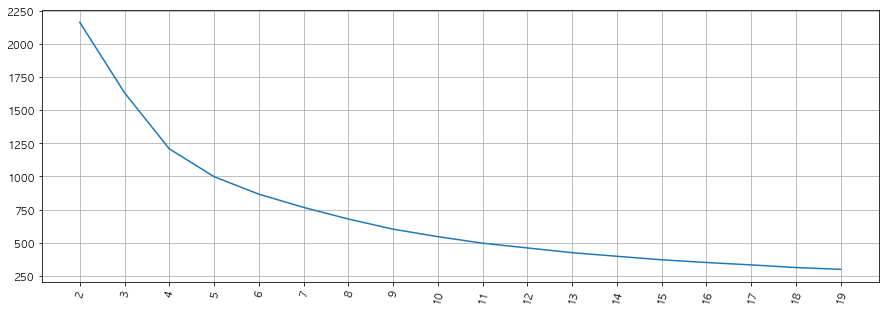

In [121]:
distorsions = []
max_loop=20
for k in range(2, max_loop):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_1st_year)
    distorsions.append(kmeans.inertia_)
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), distorsions)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.grid(True)

실루엣 기법의 경우 실루엣 점수가 다른 군집에 비해 자신의 군집과 얼마나 유사한지 측정을 한다.

실루엣 점수는 1부터 -1까지의 값으로 나타나며, 포인트가 높은값이 올바른 군집에 배치되었다고 판단한다.

아래에서는 차트가 꼬여있는?부분이 있긴하지만 실루엣 점수(y-축)이 높으면서 평평해지는 부분을 선택하면 된다.(이번 스탭2018년에서는 4를 선택)

(아래에 동일한 과정에서는 주석을 생략한다)

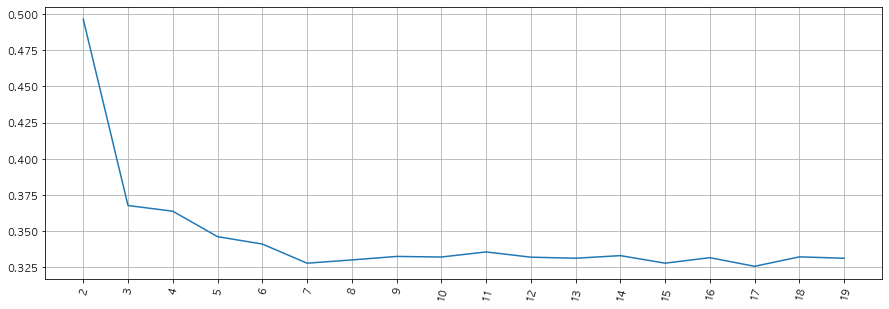

In [122]:
silhouette_score = []
for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k,  random_state=10, n_init=10)
        kmeans.fit(X_1st_year)
        silhouette_score.append(metrics.silhouette_score(X_1st_year, kmeans.labels_, random_state=10))
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), silhouette_score)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.grid(True)

In [123]:
nclust=4
#Fit with k-means
k_means_1st_year = cluster.KMeans(n_clusters=nclust)
k_means_1st_year.fit(X_1st_year)

KMeans(n_clusters=4)

In [124]:
#Extracting labels
target_labels = k_means_1st_year.predict(X_1st_year)

위 과정에서 나온 군집수를 시각화한다

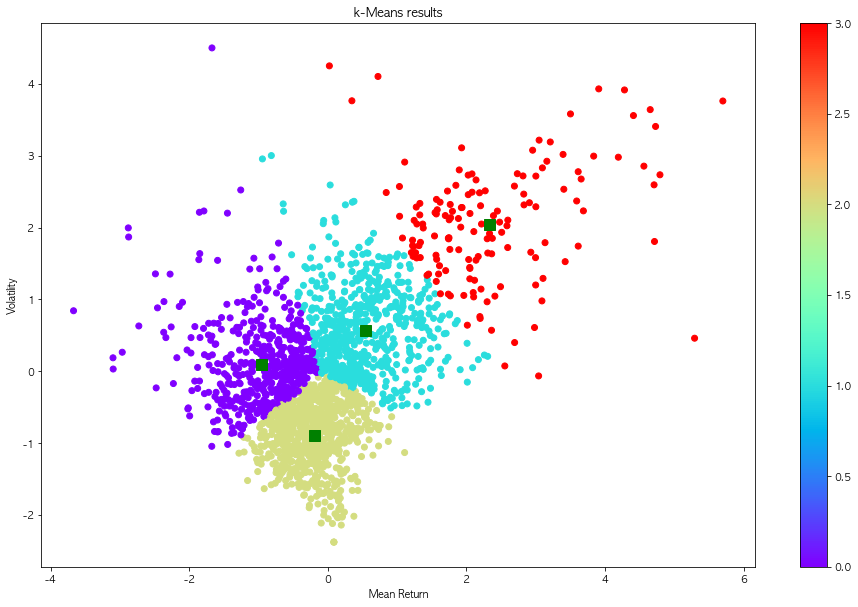

In [125]:
centroids = k_means_1st_year.cluster_centers_
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X_1st_year.iloc[:,0],X_1st_year.iloc[:,1], c = k_means_1st_year.labels_, cmap ="rainbow", label = X_1st_year.index)
ax.set_title('k-Means results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=11)

각 군집에 해당하는 종목의 개수를 시각화한다

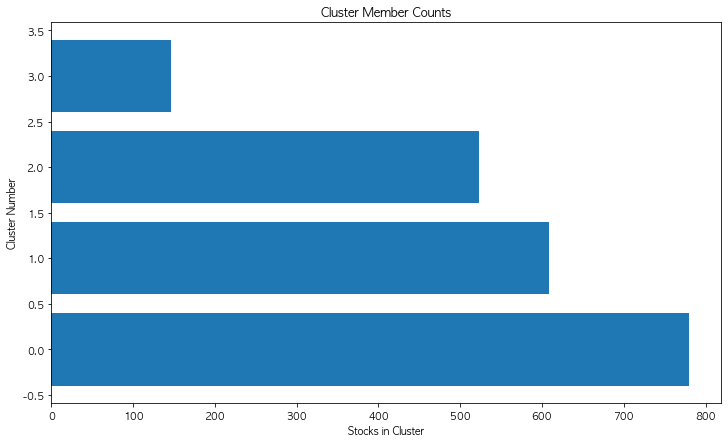

In [126]:
# show number of stocks in each cluster
clustered_series_1st_year = pd.Series(index=X_1st_year.index, data=k_means_1st_year.labels_.flatten())
# clustered stock with its cluster label
clustered_series_all = pd.Series(index=X_1st_year.index, data=k_means_1st_year.labels_.flatten())
clustered_series_1st_year = clustered_series_1st_year[clustered_series_1st_year != -1]

plt.figure(figsize=(12,7))
plt.barh(
    range(len(clustered_series_1st_year.value_counts())), # cluster labels, y axis
    clustered_series_1st_year.value_counts()
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number')
plt.show()

In [127]:
# all stock with its cluster label (including -1)
clustered_series_1st_year = pd.Series(index=X_1st_year.index, data=k_means_1st_year.fit_predict(X_1st_year).flatten())
# clustered stock with its cluster label
clustered_series_all = pd.Series(index=X_1st_year.index, data=k_means_1st_year.fit_predict(X_1st_year).flatten())
clustered_series_1st_year = clustered_series_1st_year[clustered_series_1st_year != -1]
# get the number of stocks in each cluster
counts_1st_year = clustered_series_1st_year.value_counts()

# let's visualize some clusters
cluster_vis_list_1st_year = list(counts_1st_year[(counts_1st_year>1)].index)[::-1]
cluster_vis_list_1st_year

[3, 2, 0, 1]

In [128]:
CLUSTER_SIZE_LIMIT = 9999
counts = clustered_series_1st_year.value_counts()
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
print ("Clusters formed: %d" % len(ticker_count_reduced))
print ("Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())

Clusters formed: 4
Pairs to evaluate: 1272068


In [129]:
# plot a handful of the smallest clusters
plt.figure(figsize=(24,14))
cluster_vis_list_1st_year[0:min(len(cluster_vis_list_1st_year), 1)]

[3]

<Figure size 1728x1008 with 0 Axes>

많은 군집에서 시각화를 통해 주식의 흐름을 먼저 눈으로 판단해보고

최종적으로 수익률이 0% 이상인 클러스터들만 선택한다.

(필자 팀은 분기별로 군집을 나누고 테스트를 진행했지만, 해당 코드로 다른 주기, 원하는 기간을 설정하여 테스트 해본다면 다양한 결과가 나올것이다.)

(참고로 비지도 학습이기 때문에 같은 군집수를 넣고 반복된 테스트를 한다고 하더라도, 완전히 동일한 종목의 군집이 생기지 않을 수 있다!)

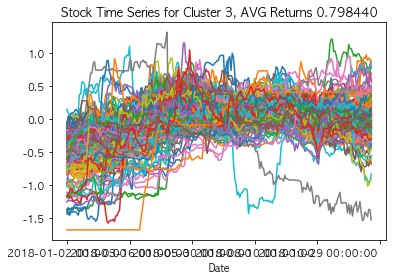

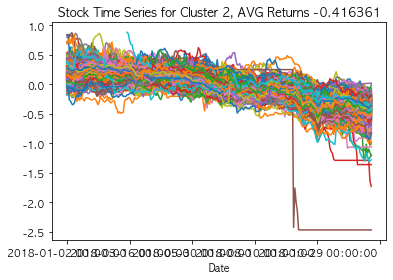

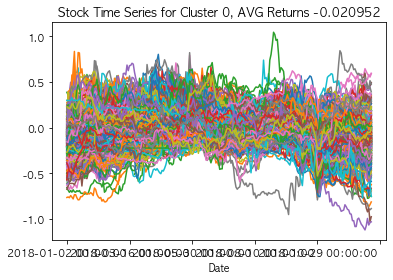

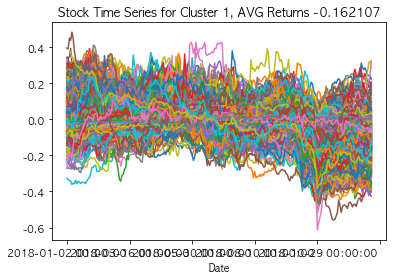

In [130]:
cluster_1st_year_result = []
for clust in cluster_vis_list_1st_year:
    tickers = list(clustered_series_1st_year[clustered_series_1st_year==clust].index)
    means = np.log(dataset_1st_year.loc[:"2022-06-01", tickers].mean())
    data = np.log(dataset_1st_year.loc[:"2022-06-01", tickers]).sub(means)
    return_value = ((dataset_1st_year.loc[:"2022-06-01", tickers].tail(30).mean()-dataset_1st_year.loc[:"2022-06-01", tickers].head(30).mean())/dataset_1st_year.loc[:"2022-06-01", tickers].head(30).mean()).mean()
    cluster_1st_year_result.append([clust, return_value])
    data.plot(title='Stock Time Series for Cluster %d, AVG Returns %f' % (clust, return_value), legend=None)
plt.show()

In [131]:
df_c_1st_year_result = pd.DataFrame(cluster_1st_year_result, columns=['clust','returns'])
df_c_1st_year_result = df_c_1st_year_result[df_c_1st_year_result['returns'] > 0]
ticker_list_1st_year = []
for idx,row in df_c_1st_year_result.iterrows():
    ticker_list_1st_year = ticker_list_1st_year + (list(clustered_series_1st_year[clustered_series_1st_year==row[0]].index.to_frame(index=False)['Code']))

## 2) 2019년도 (y-2) KOSPI, KOSDAQ 모든 종목의 일별 데이터 추출
k-mean_2nd_year : 2019 년 데이터

In [132]:
conn_2nd_year = sqlite3.connect('dacon-stock.db')
df_2nd_year = pd.read_sql_query("SELECT * FROM tb_krx_daily WHERE Date >= '2019-01-01' and Date < '2020-01-01';", conn_2nd_year)
dataset_2nd_year = df_2nd_year.set_index(["Date","Code"])[["Close"]].unstack()
dataset_2nd_year.head(10)

Close                                              \
Code                 000020  000040   000050   000060   000070   000075   
Date                                                                      
2019-01-02 00:00:00  9340.0  2030.0  10950.0  21350.0  78200.0  45850.0   
2019-01-03 00:00:00  9170.0  2042.0  11150.0  20900.0  77200.0  46700.0   
2019-01-04 00:00:00  9530.0  2042.0  11000.0  21700.0  79700.0  46650.0   
2019-01-07 00:00:00  9530.0  2046.0  11100.0  22000.0  82100.0  46950.0   
2019-01-08 00:00:00  9520.0  2058.0  11000.0  22450.0  81000.0  46700.0   
2019-01-09 00:00:00  9450.0  2079.0  11300.0  22100.0  81000.0  47250.0   
2019-01-10 00:00:00  9450.0  2103.0  11300.0  21850.0  81300.0  47250.0   
2019-01-11 00:00:00  9400.0  2184.0  11300.0  22350.0  82200.0  46950.0   
2019-01-14 00:00:00  9400.0  2176.0  11200.0  22350.0  82500.0  46950.0   
2019-01-15 00:00:00  9400.0  2201.0  11350.0  22600.0  82500.0  47150.0   

                                                         ...                 \
Code                  000080   000087   000100   000105  ... 900280  900290   
Date                                                     ...                  
2019-01-02 00:00:00  16300.0  14500.0  36647.0  33660.0  ...  647.0  2823.0   
2019-01-03 00:00:00  16200.0  14300.0  36033.0  34354.0  ...  647.0  2792.0   
2019-01-04 00:00:00  16850.0  14300.0  38575.0  34615.0  ...  655.0  2855.0   
2019-01-07 00:00:00  16750.0  14300.0  39978.0  36610.0  ...  670.0  2886.0   
2019-01-08 00:00:00  16600.0  14300.0  40330.0  36090.0  ...  678.0  2831.0   
2019-01-09 00:00:00  16700.0  14350.0  39715.0  36003.0  ...  713.0  2879.0   
2019-01-10 00:00:00  16650.0  14300.0  39978.0  36263.0  ...  740.0  2997.0   
2019-01-11 00:00:00  16450.0  14200.0  39628.0  36003.0  ...  724.0  2997.0   
2019-01-14 00:00:00  16300.0  14100.0  39189.0  35830.0  ...  728.0  2965.0   
2019-01-15 00:00:00  16250.0  14150.0  40943.0  35915.0  ...  748.0  2997.0   

                                                                               \
Code                 900300  900310  900340   950110  950130  950140   950160   
Date                                                                            
2019-01-02 00:00:00  2645.0  1670.0  1385.0  15700.0  4410.0  6040.0  43400.0   
2019-01-03 00:00:00  2805.0  1620.0  1465.0  15500.0  4180.0  6070.0  41450.0   
2019-01-04 00:00:00  2780.0  1605.0  1500.0  14600.0  4365.0  6100.0  43050.0   
2019-01-07 00:00:00  2695.0  1645.0  1480.0  14300.0  4470.0  6130.0  41850.0   
2019-01-08 00:00:00  2685.0  1625.0  1450.0  15250.0  4305.0  6020.0  41000.0   
2019-01-09 00:00:00  2665.0  1675.0  1515.0  15350.0  4330.0  6090.0  40950.0   
2019-01-10 00:00:00  2630.0  1725.0  1505.0  15100.0  4160.0  6060.0  40900.0   
2019-01-11 00:00:00  2590.0  1755.0  1505.0  15100.0  4160.0  5790.0  40400.0   
2019-01-14 00:00:00  2540.0  1795.0  1510.0  15050.0  4115.0  5890.0  38800.0   
2019-01-15 00:00:00  2545.0  1825.0  1480.0  14800.0  4110.0  5860.0  39000.0   

                             
Code                 950170  
Date                         
2019-01-02 00:00:00  6580.0  
2019-01-03 00:00:00  6230.0  
2019-01-04 00:00:00  6260.0  
2019-01-07 00:00:00  6250.0  
2019-01-08 00:00:00  6280.0  
2019-01-09 00:00:00  6450.0  
2019-01-10 00:00:00  6590.0  
2019-01-11 00:00:00  6600.0  
2019-01-14 00:00:00  6730.0  
2019-01-15 00:00:00  6720.0  

[10 rows x 2246 columns]

## 2. K-Mean을 통한 종목 군집화(변동성과 수익성을 고려), (과거 동일 분기 및 최근 트랜드 반영)

In [133]:
print('Null Values =',dataset_2nd_year.isnull().values.any())

Null Values = True


In [134]:
missing_fractions_2nd_year = dataset_2nd_year.isnull().mean().sort_values(ascending=False)
drop_list_2nd_year = sorted(list(missing_fractions_2nd_year[missing_fractions_2nd_year > 0.3].index))
dataset_2nd_year.drop(labels=drop_list_2nd_year, axis=1, inplace=True)
dataset_2nd_year.shape

(246, 2155)

In [135]:
dataset_2nd_year = dataset_2nd_year.fillna(method='ffill')

In [136]:
returns_2nd_year = pd.DataFrame(dataset_2nd_year.pct_change().mean() * len(dataset_2nd_year))
returns_2nd_year.columns = ['Returns']
returns_2nd_year['Volatility'] = dataset_2nd_year.pct_change().std() * np.sqrt(len(dataset_2nd_year))
data_2nd_year = returns_2nd_year

전 종목에 대한 수익률과 변동성을 스캐일링 시켜줘야 k-mean이 가능

In [137]:
scaler_2nd_year = StandardScaler().fit(data_2nd_year)
rescaledDataset_2nd_year = pd.DataFrame(scaler_2nd_year.fit_transform(data_2nd_year),columns = data_2nd_year.columns, index = data_2nd_year.index)
# summarize transformed data
rescaledDataset_2nd_year.head(2)
X_2nd_year=rescaledDataset_2nd_year
X_2nd_year.head(2)

Returns  Volatility
      Code                        
Close 000020 -0.520848   -0.908001
      000040 -1.542531   -0.249348

K-Mean에서는 군집수를 찾을때 보통 엘보우 기법을 많이 사용하지만, 정확한 판단을 위해 실루엣기법도 함께 그리고 판단하기로 결정

엘보우 기법은 기본적으로 오차제곱합 기준으로 군집을 나눈다.

엘보우가 어느 지점에서 수평적인 움직임을 가져가는 부분에서의 수를 군집으로 설정하는데, 그 말은 해당 군집수 부터 오차제곱합이 정체되기 시작한다는 뜻이다

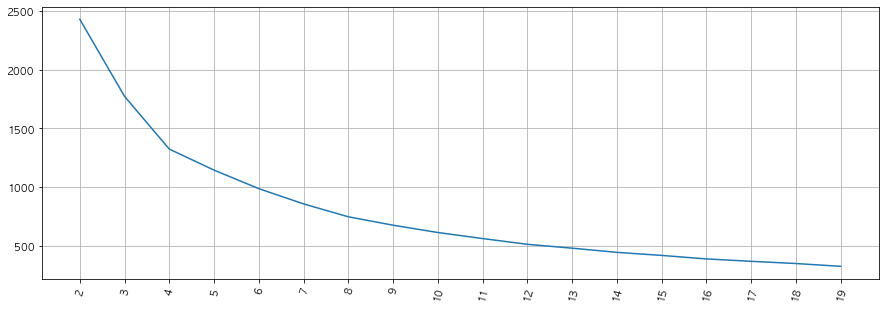

In [138]:
distorsions = []
max_loop=20
for k in range(2, max_loop):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_2nd_year)
    distorsions.append(kmeans.inertia_)
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), distorsions)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.grid(True)

실루엣 기법의 경우 실루엣 점수가 다른 군집에 비해 자신의 군집과 얼마나 유사한지 측정을 한다.

실루엣 점수는 1부터 -1까지의 값으로 나타나며, 포인트가 높은값이 올바른 군집에 배치되었다고 판단한다.

아래에서는 차트가 꼬여있는?부분이 있긴하지만 실루엣 점수(y-축)이 높으면서 평평해지는 부분을 선택하면 된다.(이번 스탭2019년에서는 4를 선택)

(아래에 동일한 과정에서는 주석을 생략한다)

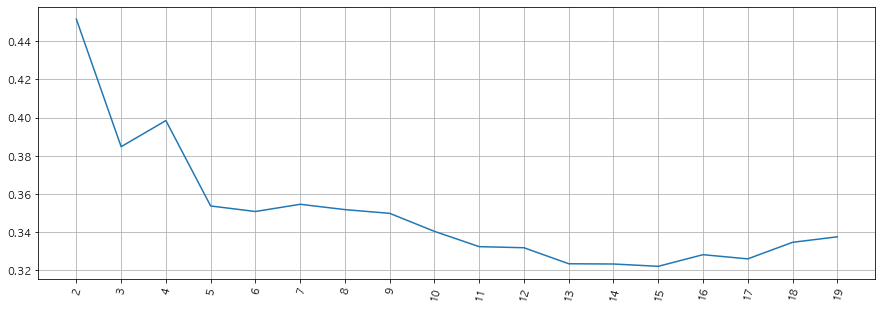

In [139]:
silhouette_score = []
for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k,  random_state=10, n_init=10)
        kmeans.fit(X_2nd_year)
        silhouette_score.append(metrics.silhouette_score(X_2nd_year, kmeans.labels_, random_state=10))
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), silhouette_score)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.grid(True)

In [140]:
nclust=4
#Fit with k-means
k_means_2nd_year = cluster.KMeans(n_clusters=nclust)
k_means_2nd_year.fit(X_2nd_year)

KMeans(n_clusters=4)

In [141]:
#Extracting labels
target_labels = k_means_2nd_year.predict(X_2nd_year)

위 과정에서 나온 군집수를 시각화함

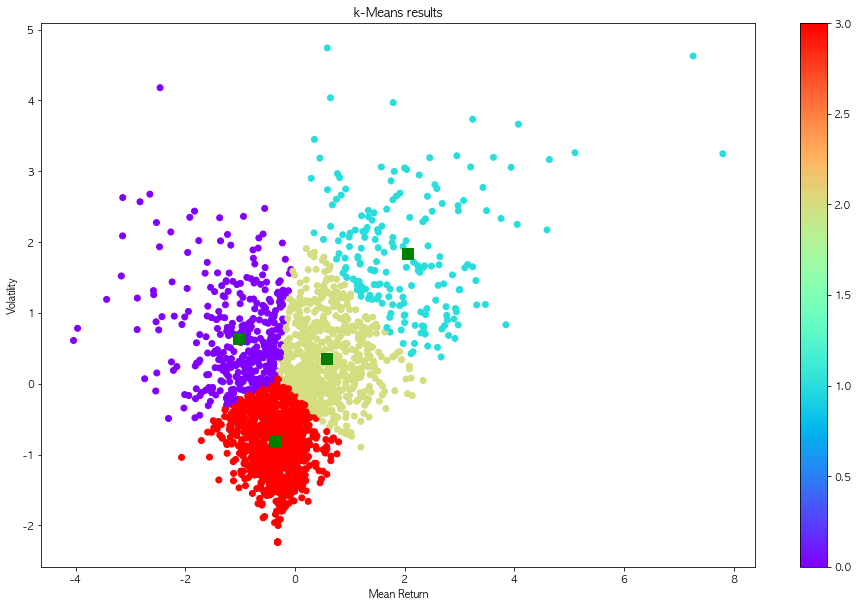

In [142]:
centroids = k_means_2nd_year.cluster_centers_
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X_2nd_year.iloc[:,0],X_2nd_year.iloc[:,1], c = k_means_2nd_year.labels_, cmap ="rainbow", label = X_2nd_year.index)
ax.set_title('k-Means results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=11)

각 군집에 해당하는 종목의 개수를 시각화한다

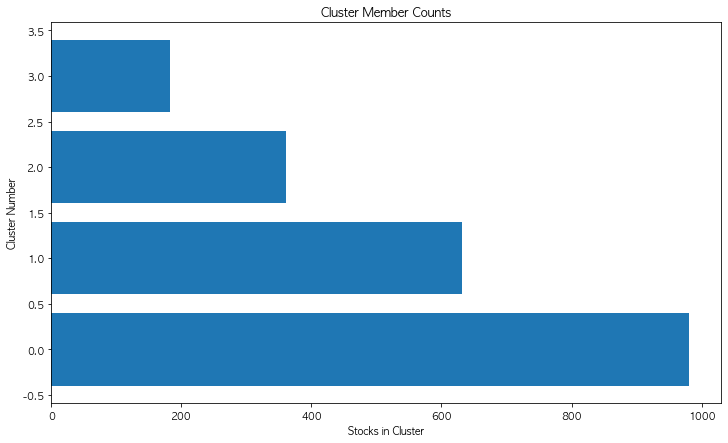

In [143]:
# show number of stocks in each cluster
clustered_series_2nd_year = pd.Series(index=X_2nd_year.index, data=k_means_2nd_year.labels_.flatten())
# clustered stock with its cluster label
clustered_series_all = pd.Series(index=X_2nd_year.index, data=k_means_2nd_year.labels_.flatten())
clustered_series_2nd_year = clustered_series_2nd_year[clustered_series_2nd_year != -1]

plt.figure(figsize=(12,7))
plt.barh(
    range(len(clustered_series_2nd_year.value_counts())), # cluster labels, y axis
    clustered_series_2nd_year.value_counts()
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number')
plt.show()

In [144]:
# all stock with its cluster label (including -1)
clustered_series_2nd_year = pd.Series(index=X_2nd_year.index, data=k_means_2nd_year.fit_predict(X_2nd_year).flatten())
# clustered stock with its cluster label
clustered_series_all = pd.Series(index=X_2nd_year.index, data=k_means_2nd_year.fit_predict(X_2nd_year).flatten())
clustered_series_2nd_year = clustered_series_2nd_year[clustered_series_2nd_year != -1]
# get the number of stocks in each cluster
counts_2nd_year = clustered_series_2nd_year.value_counts()

# let's visualize some clusters
cluster_vis_list_2nd_year = list(counts_2nd_year[(counts_2nd_year>1)].index)[::-1]
cluster_vis_list_2nd_year

[3, 2, 0, 1]

In [145]:
CLUSTER_SIZE_LIMIT = 9999
counts = clustered_series_2nd_year.value_counts()
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
print ("Clusters formed: %d" % len(ticker_count_reduced))
print ("Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())

Clusters formed: 4
Pairs to evaluate: 1520210


In [146]:
# plot a handful of the smallest clusters
plt.figure(figsize=(24,14))
cluster_vis_list_2nd_year[0:min(len(cluster_vis_list_2nd_year), 1)]

[3]

<Figure size 1728x1008 with 0 Axes>

많은 군집에서 시각화를 통해 주식의 흐름을 먼저 눈으로 판단해보고

최종적으로 수익률이 0% 이상인 클러스터들만 선택한다.

(필자 팀은 분기별로 군집을 나누고 테스트를 진행했지만, 해당 코드로 다른 주기, 원하는 기간을 설정하여 테스트 해본다면 다양한 결과가 나올것이다.)

(참고로 비지도 학습이기 때문에 같은 군집수를 넣고 반복된 테스트를 한다고 하더라도, 완전히 동일한 종목의 군집이 생기지 않을 수 있다!)

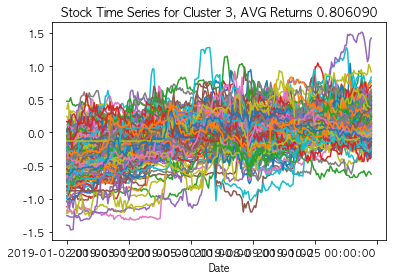

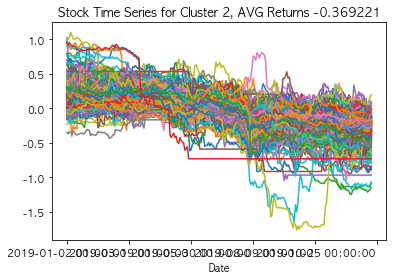

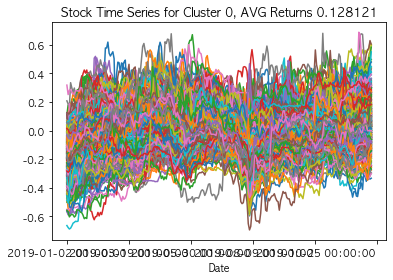

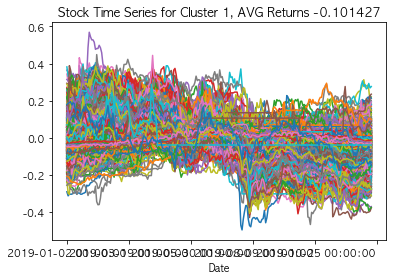

In [147]:
cluster_2nd_year_result = []
for clust in cluster_vis_list_2nd_year:
    tickers = list(clustered_series_2nd_year[clustered_series_2nd_year==clust].index)
    means = np.log(dataset_2nd_year.loc[:"2022-06-01", tickers].mean())
    data = np.log(dataset_2nd_year.loc[:"2022-06-01", tickers]).sub(means)
    return_value = ((dataset_2nd_year.loc[:"2022-06-01", tickers].tail(30).mean()-dataset_2nd_year.loc[:"2022-06-01", tickers].head(30).mean())/dataset_2nd_year.loc[:"2022-06-01", tickers].head(30).mean()).mean()
    cluster_2nd_year_result.append([clust, return_value])
    data.plot(title='Stock Time Series for Cluster %d, AVG Returns %f' % (clust, return_value), legend=None)
plt.show()

In [148]:
df_c_2nd_year_result = pd.DataFrame(cluster_2nd_year_result, columns=['clust','returns'])
df_c_2nd_year_result = df_c_2nd_year_result[df_c_2nd_year_result['returns'] > 0]
ticker_list_2nd_year = []
for idx,row in df_c_2nd_year_result.iterrows():
    ticker_list_2nd_year = ticker_list_2nd_year + (list(clustered_series_2nd_year[clustered_series_2nd_year==row[0]].index.to_frame(index=False)['Code']))

## 1) 2020년도 (y-1) KOSPI, KOSDAQ 모든 종목의 일별 데이터 추출
k-mean_3rd_year : 2020 년 데이터

In [149]:
conn_3rd_year = sqlite3.connect('dacon-stock.db')
df_3rd_year = pd.read_sql_query("SELECT * FROM tb_krx_daily WHERE Date >= '2020-01-01' and Date < '2021-01-01';", conn_3rd_year)
dataset_3rd_year = df_3rd_year.set_index(["Date","Code"])[["Close"]].unstack()
dataset_3rd_year.head(10)

Close                                             \
Code                 000020  000040  000050   000060   000070   000075   
Date                                                                     
2020-01-02 00:00:00  8400.0  1145.0  9580.0  17150.0  67300.0  43050.0   
2020-01-03 00:00:00  8360.0  1133.0  9590.0  17150.0  66700.0  43050.0   
2020-01-06 00:00:00  8180.0  1108.0  9540.0  16650.0  64200.0  43150.0   
2020-01-07 00:00:00  8160.0  1076.0  9560.0  16400.0  64900.0  42950.0   
2020-01-08 00:00:00  7930.0  1060.0  9270.0  16150.0  61700.0  42050.0   
2020-01-09 00:00:00  7900.0  1088.0  9340.0  16350.0  61400.0  42250.0   
2020-01-10 00:00:00  8100.0  1133.0  9370.0  16500.0  60300.0  42250.0   
2020-01-13 00:00:00  8220.0  1149.0  9360.0  16400.0  61000.0  42400.0   
2020-01-14 00:00:00  8140.0  1149.0  9360.0  16450.0  61900.0  42450.0   
2020-01-15 00:00:00  8090.0  1129.0  9430.0  16450.0  61700.0  42500.0   

                                                         ...                  \
Code                  000080   000087   000100   000105  ...  900300  900310   
Date                                                     ...                   
2020-01-02 00:00:00  28900.0  17300.0  42402.0  38125.0  ...  1400.0  1940.0   
2020-01-03 00:00:00  28550.0  17200.0  42219.0  38034.0  ...  1375.0  1935.0   
2020-01-06 00:00:00  28650.0  17250.0  41486.0  37306.0  ...  1300.0  1900.0   
2020-01-07 00:00:00  28450.0  17200.0  42219.0  37579.0  ...  1350.0  2015.0   
2020-01-08 00:00:00  27700.0  16900.0  41395.0  37215.0  ...  1245.0  1920.0   
2020-01-09 00:00:00  27850.0  17000.0  42219.0  37215.0  ...  1300.0  2015.0   
2020-01-10 00:00:00  27200.0  16900.0  42493.0  37761.0  ...  1340.0  2110.0   
2020-01-13 00:00:00  27400.0  17000.0  42768.0  37852.0  ...  1415.0  2160.0   
2020-01-14 00:00:00  29050.0  17500.0  42585.0  37670.0  ...  1390.0  2090.0   
2020-01-15 00:00:00  31650.0  18250.0  42402.0  37670.0  ...  1410.0  2070.0   

                                                                             \
Code                 900340   950110  950130  950140  950160  950170 950190   
Date                                                                          
2020-01-02 00:00:00  2200.0  10150.0  2120.0  4470.0  8010.0  8920.0    NaN   
2020-01-03 00:00:00  2160.0   9970.0  2130.0  4695.0  8010.0  8910.0    NaN   
2020-01-06 00:00:00  2110.0   9750.0  2075.0  4700.0  8010.0  8550.0    NaN   
2020-01-07 00:00:00  2155.0  10000.0  2080.0  4730.0  8010.0  8490.0    NaN   
2020-01-08 00:00:00  2020.0   9730.0  1960.0  4635.0  8010.0  8080.0    NaN   
2020-01-09 00:00:00  2165.0   9920.0  2010.0  4685.0  8010.0  8350.0    NaN   
2020-01-10 00:00:00  2225.0  10250.0  2020.0  4650.0  8010.0  8350.0    NaN   
2020-01-13 00:00:00  2285.0  10700.0  2035.0  4715.0  8010.0  8610.0    NaN   
2020-01-14 00:00:00  2210.0  10900.0  2010.0  4710.0  8010.0  8480.0    NaN   
2020-01-15 00:00:00  2250.0  11050.0  2015.0  4695.0  8010.0  8550.0    NaN   

                            
Code                950200  
Date                        
2020-01-02 00:00:00    NaN  
2020-01-03 00:00:00    NaN  
2020-01-06 00:00:00    NaN  
2020-01-07 00:00:00    NaN  
2020-01-08 00:00:00    NaN  
2020-01-09 00:00:00    NaN  
2020-01-10 00:00:00    NaN  
2020-01-13 00:00:00    NaN  
2020-01-14 00:00:00    NaN  
2020-01-15 00:00:00    NaN  

[10 rows x 2339 columns]

## 2. K-Mean을 통한 종목 군집화(변동성과 수익성을 고려), (과거 동일 분기 및 최근 트랜드 반영)

In [150]:
print('Null Values =',dataset_3rd_year.isnull().values.any())

Null Values = True


In [151]:
missing_fractions_3rd_year = dataset_3rd_year.isnull().mean().sort_values(ascending=False)
drop_list_3rd_year = sorted(list(missing_fractions_3rd_year[missing_fractions_3rd_year > 0.3].index))
dataset_3rd_year.drop(labels=drop_list_3rd_year, axis=1, inplace=True)
dataset_3rd_year.shape

(248, 2259)

In [152]:
dataset_3rd_year = dataset_3rd_year.fillna(method='ffill')

In [153]:
returns_3rd_year = pd.DataFrame(dataset_3rd_year.pct_change().mean() * len(dataset_3rd_year))
returns_3rd_year.columns = ['Returns']
returns_3rd_year['Volatility'] = dataset_3rd_year.pct_change().std() * np.sqrt(len(dataset_3rd_year))
data_3rd_year = returns_3rd_year

전 종목에 대한 수익률과 변동성을 스캐일링 시켜줘야 k-mean이 가능

In [154]:
scaler_3rd_year = StandardScaler().fit(data_3rd_year)
rescaledDataset_3rd_year = pd.DataFrame(scaler_3rd_year.fit_transform(data_3rd_year),columns = data_3rd_year.columns, index = data_3rd_year.index)
# summarize transformed data
rescaledDataset_3rd_year.head(2)
X_3rd_year=rescaledDataset_3rd_year
X_3rd_year.head(2)

Returns  Volatility
      Code                        
Close 000020  1.446303    1.012916
      000040  0.020395    1.320301

K-Mean에서는 군집수를 찾을때 보통 엘보우 기법을 많이 사용하지만, 정확한 판단을 위해 실루엣기법도 함께 그리고 판단하기로 결정

엘보우 기법은 기본적으로 오차제곱합 기준으로 군집을 나눈다.

엘보우가 어느 지점에서 수평적인 움직임을 가져가는 부분에서의 수를 군집으로 설정하는데, 그 말은 해당 군집수 부터 오차제곱합이 정체되기 시작한다는 뜻이다

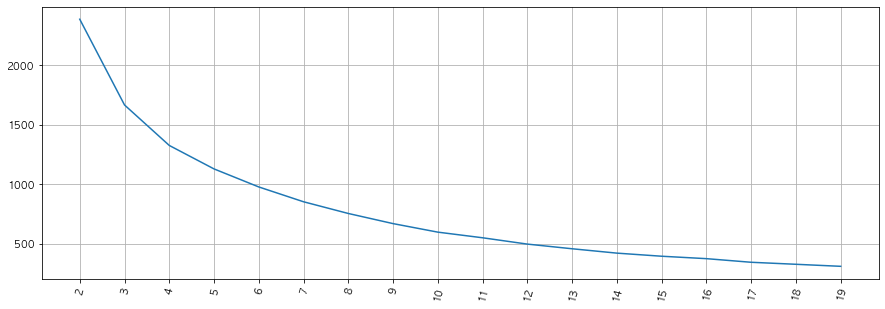

In [155]:
distorsions = []
max_loop=20
for k in range(2, max_loop):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_3rd_year)
    distorsions.append(kmeans.inertia_)
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), distorsions)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.grid(True)

실루엣 기법의 경우 실루엣 점수가 다른 군집에 비해 자신의 군집과 얼마나 유사한지 측정을 한다.

실루엣 점수는 1부터 -1까지의 값으로 나타나며, 포인트가 높은값이 올바른 군집에 배치되었다고 판단한다.

아래에서는 차트가 꼬여있는?부분이 있긴하지만 실루엣 점수(y-축)이 높으면서 평평해지는 부분을 선택하면 된다.(이번 스탭2020년에서는 4를 선택)

(아래에 동일한 과정에서는 주석을 생략한다)

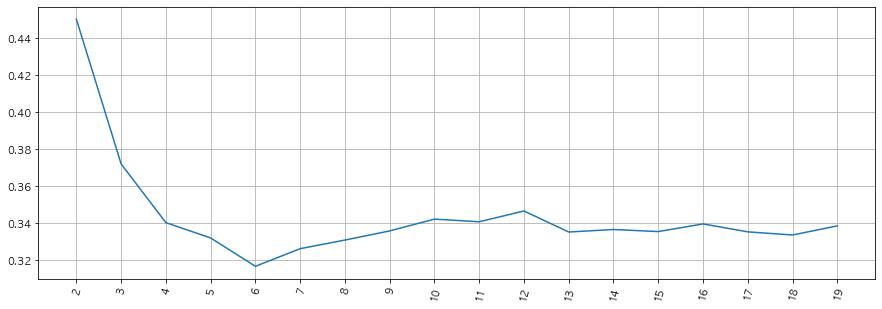

In [156]:
silhouette_score = []
for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k,  random_state=10, n_init=10)
        kmeans.fit(X_3rd_year)
        silhouette_score.append(metrics.silhouette_score(X_3rd_year, kmeans.labels_, random_state=10))
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), silhouette_score)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.grid(True)

In [157]:
nclust=4
#Fit with k-means
k_means_3rd_year = cluster.KMeans(n_clusters=nclust)
k_means_3rd_year.fit(X_3rd_year)

KMeans(n_clusters=4)

In [158]:
#Extracting labels
target_labels = k_means_3rd_year.predict(X_3rd_year)

위 과정에서 나온 군집수를 시각화함

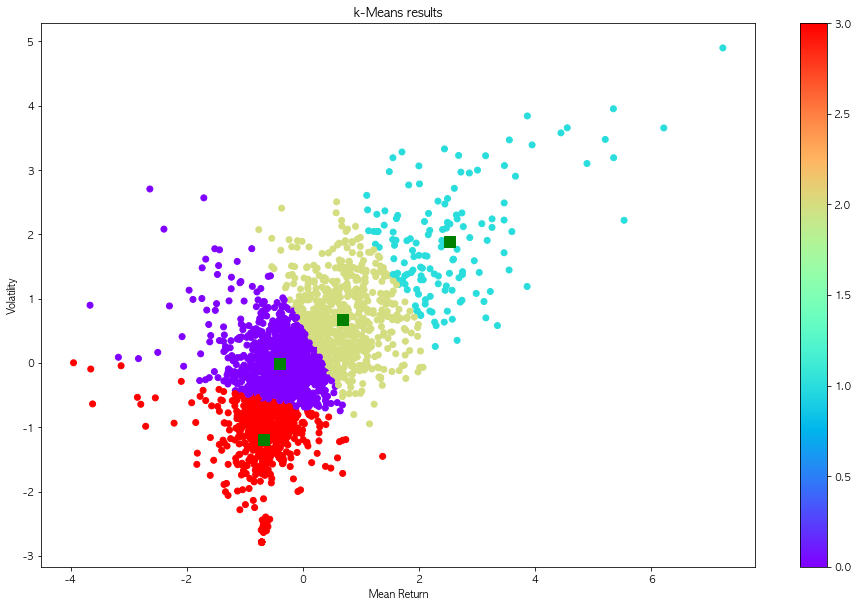

In [159]:
centroids = k_means_3rd_year.cluster_centers_
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X_3rd_year.iloc[:,0],X_3rd_year.iloc[:,1], c = k_means_3rd_year.labels_, cmap ="rainbow", label = X_3rd_year.index)
ax.set_title('k-Means results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=11)

각 군집에 해당하는 종목의 개수를 시각화한다

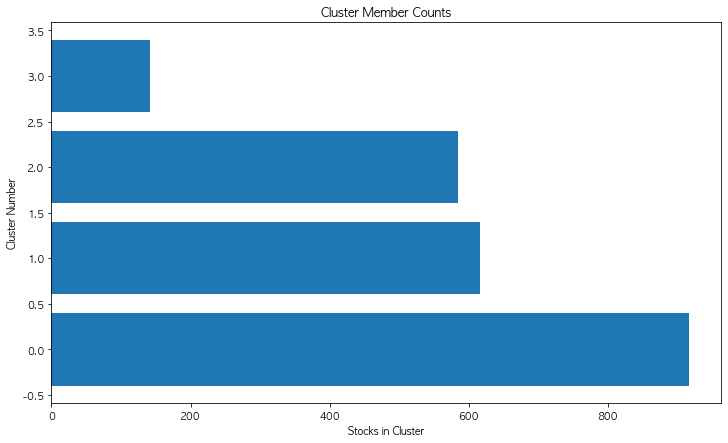

In [160]:
# show number of stocks in each cluster
clustered_series_3rd_year = pd.Series(index=X_3rd_year.index, data=k_means_3rd_year.labels_.flatten())
# clustered stock with its cluster label
clustered_series_all = pd.Series(index=X_3rd_year.index, data=k_means_3rd_year.labels_.flatten())
clustered_series_3rd_year = clustered_series_3rd_year[clustered_series_3rd_year != -1]

plt.figure(figsize=(12,7))
plt.barh(
    range(len(clustered_series_3rd_year.value_counts())), # cluster labels, y axis
    clustered_series_3rd_year.value_counts()
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number')
plt.show()

In [161]:
temp = clustered_series_3rd_year.value_counts()
temp

0    917
2    616
3    585
1    141
dtype: int64

In [162]:
# all stock with its cluster label (including -1)
clustered_series_3rd_year = pd.Series(index=X_3rd_year.index, data=k_means_3rd_year.fit_predict(X_3rd_year).flatten())
# clustered stock with its cluster label
clustered_series_all = pd.Series(index=X_3rd_year.index, data=k_means_3rd_year.fit_predict(X_3rd_year).flatten())
clustered_series_3rd_year = clustered_series_3rd_year[clustered_series_3rd_year != -1]
# get the number of stocks in each cluster
counts_3rd_year = clustered_series_3rd_year.value_counts()

# let's visualize some clusters
cluster_vis_list_3rd_year = list(counts_3rd_year[(counts_3rd_year>1)].index)[::-1]
cluster_vis_list_3rd_year

[1, 3, 2, 0]

In [163]:
CLUSTER_SIZE_LIMIT = 9999
counts = clustered_series_3rd_year.value_counts()
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
print ("Clusters formed: %d" % len(ticker_count_reduced))
print ("Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())

Clusters formed: 4
Pairs to evaluate: 1579292


In [164]:
# plot a handful of the smallest clusters
plt.figure(figsize=(24,14))
cluster_vis_list_3rd_year[0:min(len(cluster_vis_list_3rd_year), 1)]

[1]

<Figure size 1728x1008 with 0 Axes>

많은 군집에서 시각화를 통해 주식의 흐름을 먼저 눈으로 판단해보고

최종적으로 수익률이 0% 이상인 클러스터들만 선택한다.

(필자 팀은 분기별로 군집을 나누고 테스트를 진행했지만, 해당 코드로 다른 주기, 원하는 기간을 설정하여 테스트 해본다면 다양한 결과가 나올것이다.)

(참고로 비지도 학습이기 때문에 같은 군집수를 넣고 반복된 테스트를 한다고 하더라도, 완전히 동일한 종목의 군집이 생기지 않을 수 있다!)

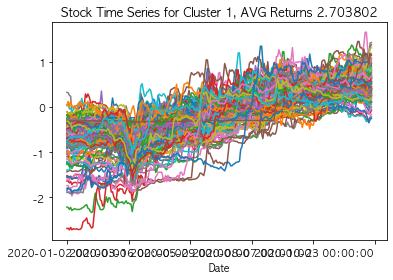

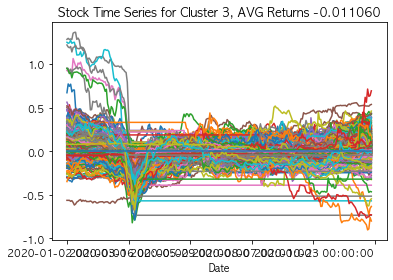

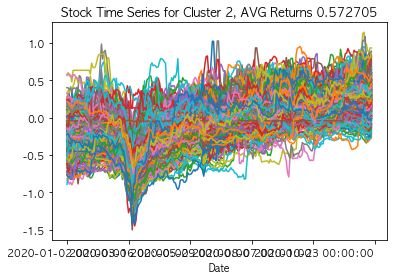

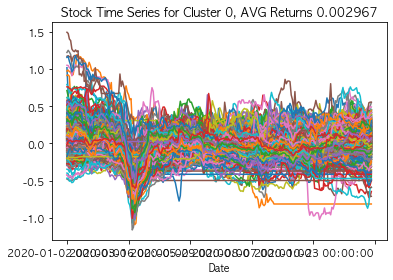

In [165]:
cluster_3rd_year_result = []
for clust in cluster_vis_list_3rd_year:
    tickers = list(clustered_series_3rd_year[clustered_series_3rd_year==clust].index)
    means = np.log(dataset_3rd_year.loc[:"2022-06-01", tickers].mean())
    data = np.log(dataset_3rd_year.loc[:"2022-06-01", tickers]).sub(means)
    return_value = ((dataset_3rd_year.loc[:"2022-06-01", tickers].tail(30).mean()-dataset_3rd_year.loc[:"2022-06-01", tickers].head(30).mean())/dataset_3rd_year.loc[:"2022-06-01", tickers].head(30).mean()).mean()
    cluster_3rd_year_result.append([clust, return_value])
    data.plot(title='Stock Time Series for Cluster %d, AVG Returns %f' % (clust, return_value), legend=None)
plt.show()

In [166]:
df_c_3rd_year_result = pd.DataFrame(cluster_3rd_year_result, columns=['clust','returns'])
df_c_3rd_year_result = df_c_3rd_year_result[df_c_3rd_year_result['returns'] > 0]
ticker_list_3rd_year = []
for idx,row in df_c_3rd_year_result.iterrows():
    ticker_list_3rd_year = ticker_list_3rd_year + (list(clustered_series_3rd_year[clustered_series_3rd_year==row[0]].index.to_frame(index=False)['Code']))

위에서 나온 A, B, C 군집들에서 공통적으로 속하는 종목을 추리는 과정을 진행한다

In [167]:
print(len(ticker_list_1st_year))
print(len(ticker_list_2nd_year))
print(len(ticker_list_3rd_year))
result = list(set(ticker_list_1st_year) & set(ticker_list_2nd_year) & set(ticker_list_3rd_year))
print(len(result))

146
810
1678
57


## 3.위 최종 교집합 종목 구성에서 벨류지표( PER, PBR, EPS, DIV, DPS)로 순위 나열(Ranking) 후 점수합산

→ 많은 종목의 군집에서도 충분히 저평가 되어있으며 상승할 여력이 있는 종목을 선정해야함

→ 그 과정을 퀀트지표(value kpi)를 통해 선정 (정량적인 투자를 말하면서, 퀀트적인 요소를 빼 놓을 수 없음)

→ 가장 기본적이면서도 강력한 다섯가지 지표를 통해 랭킹을 선정하고 점수를 부여하여, 가장 높은 순위의 종목을 선택

 *  최종 종목 리스트 구성 (만약 100개가 넘을 경우 100개로 한정시키기로함)

1. PER, PBR: 낮은 수치가 상위 랭킹
2. EPS, DIV, DPS: 높은 수치가 상위 랭킹
3. 각 지표에서의 순위를 모두 합산하여 가장 낮은 수(높은 랭킹)을 기록한 종목을 선택
4. 종목 수 설정 : limit 100종목

#### 1) 종목별로 fundamental 지표를 가져온다.

In [168]:
def get_fundamental_df(date):
    tickers = stock.get_market_ticker_list(date, market='ALL')
    corp = []

    for ticker in tickers:
        corp_name = stock.get_market_ticker_name(ticker)
        corp.append([ticker, corp_name])

    df = pd.DataFrame(data= corp, columns=['code','종목명'])
    df = df.set_index('code')

    df_1 = stock.get_market_fundamental_by_ticker(date, market='ALL')

    df = pd.merge(df, df_1, left_index=True, right_index=True)

    return df

df = get_fundamental_df('20210104')
input = result
input

['078130',
 '000520',
 '004985',
 '003580',
 '063440',
 '082800',
 '091590',
 '143160',
 '008355',
 '008350',
 '002995',
 '018290',
 '004565',
 '009810',
 '072520',
 '228760',
 '009460',
 '067630',
 '066430',
 '211050',
 '013360',
 '067160',
 '007110',
 '039200',
 '004545',
 '226360',
 '002100',
 '028300',
 '148780',
 '074610',
 '026150',
 '036480',
 '061970',
 '028100',
 '002785',
 '154030',
 '078590',
 '001140',
 '031820',
 '234100',
 '105740',
 '101360',
 '277880',
 '054930',
 '263720',
 '150840',
 '001260',
 '011390',
 '014990',
 '198440',
 '126340',
 '002210',
 '215200',
 '109070',
 '219420',
 '252500',
 '032820']

In [169]:
df1=df.reindex(index=input)

In [170]:
BPS = df1['BPS'] > 0
PER = df1['PER'] > 0
PBR = df1['PBR'] > 0
EPS = df1['EPS'] > 0
DIV = df1['DIV'] > 0
DPS = df1['DPS'] > 0

# 두가지 조건를 동시에 충족하는 데이터를 필터링하여 새로운 변수에 저장합니다. (AND)
df1 = df1[BPS & PER & PBR & EPS & DIV & DPS]
df1

,종목명,BPS,PER,PBR,EPS,DIV,DPS
000520,삼일제약,9580.0,157.75,2.12,129.0,0.74,150.0
091590,남화토건,11305.0,29.48,1.11,424.0,0.56,70.0
143160,아이디스,14218.0,150.81,1.96,185.0,0.90,250.0
009460,한창제지,1440.0,19.20,1.67,125.0,0.83,20.0
013360,일성건설,1688.0,38.33,0.68,30.0,1.30,15.0
067160,아프리카TV,10346.0,19.50,5.96,3164.0,0.89,550.0
002100,경농,8484.0,48.03,1.44,254.0,1.80,220.0
036480,대성미생물,9235.0,21.87,1.78,750.0,0.52,85.0
061970,엘비세미콘,3419.0,19.69,4.28,744.0,0.34,50.0
028100,동아지질,16860.0,9.79,0.98,1686.0,1.21,200.0


In [171]:
low_rank = df1[['PER','PBR']].rank(numeric_only=True, ascending=True)
high_rank = df1[['BPS','EPS', 'DIV','DPS']].rank(numeric_only=True, ascending=False)
rank= pd.merge(low_rank, high_rank, right_index=True, left_index=True)
rank['ranking']=rank.sum(axis=1)
rank=rank.sort_values('ranking')
rank = rank.head(100)

In [172]:
result = list(rank.index)
len(result)

15

####  종목별로 회사명을 가져옴 (백테스트 시 활용 용도)

In [173]:
def return_name(market):
    Market = []

    for ticker in market:
        Value =stock.get_market_ticker_name(ticker)
        Market.append([Value,ticker])

    df = pd.DataFrame(Market,columns=['회사명','상장번호'])
    return df

In [174]:
KRX = stock.get_market_ticker_list(market="KRX")
db1 = return_name(result)
db1.head(10)

,회사명,상장번호
0,메가스터디교육,215200
1,동아지질,028100
2,디케이락,105740
3,아프리카TV,067160
4,부산산업,011390
5,경농,002100
6,남화토건,091590
7,아이디스,143160
8,대성미생물,036480
9,한창제지,009460


## 4. 몬테카를로 시뮬레이션을 통해 종목에 최적인 비중 선택 (리스크 or 샤프지수)

최종적인 리스트가 나왔으니, 이제 투자를 해야한다.

하지만 개별적으로 사는 것이 아닌 최적의 비중을 고려하여 분산투자를 하는것이 바람직하다고 생각하여, 우리 팀은 종목 비중에 따른 리스크와 샤프지수를 개산하기로 하였다.

몬테카를로 시뮬레이션은 의사결정자의 개입이 없는 객관적인 미래예측 방식으로 여러 시나리오를 기반하여 복수개의 의사결정 안을 도출하고 최적의 결정을 선정함

그렇기 때문에 몬테카를로 시뮬레이션은 특히 예측이 힘든 금융시장에서 자주 사용된다

간단히 말해서 몬테카를로 시뮬레이션은 불확실한 변수에 대한 기본 분포에서 생성된 다양한 난수를 사용하여 엄청난 양의 시행을 실행하기 때문에, 이 알고리즘을 사용하기로 함

먼저 최근 1년동안의 위 선택된 종목들의 움직임(수익률)을 파악해야하니 종가를 모두 조회해준다.

In [175]:
stocks = result
df_res = pd.DataFrame()

for i in stocks:
    bun=db1[db1['상장번호']==i]
    번호=bun.iloc[0,1]
    df_res[i] = stock.get_market_ohlcv_by_date("20200101", "20201231", 번호)['종가']


In [176]:
df_res

,215200,028100,105740,067160,011390,002100,091590,143160,036480,009460,013360,000520,061970,198440,252500
날짜,,,,,,,,,,,,,,,
2020-01-02,40300,19150,9710,65700,145000,11500,16600,25300,16100,2985,1290,10525,8080,3100,1482
2020-01-03,40100,19150,9460,60500,148000,11600,16650,25450,16400,2905,1305,10575,8190,3155,1467
2020-01-06,39600,18800,9490,55400,142500,11200,15900,23950,16100,2930,1245,10075,8000,3020,1414
2020-01-07,40000,18600,9540,54500,144500,11400,16150,23950,16150,2960,1260,10225,7840,3060,1469
2020-01-08,39200,17500,9490,53700,137000,10800,15350,23500,15100,2775,1205,9700,7940,2890,1407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,36500,15500,14000,59500,113500,11500,13200,24550,15750,2505,1090,10500,11800,2990,1882
2020-12-24,37400,15750,14100,59800,113500,11700,13450,25750,15750,2530,1125,10400,12550,3025,1877
2020-12-28,38700,15750,13800,60800,110500,11600,13100,25200,15450,2330,1120,10225,13200,2975,1885


먼저 리스크의 경우 개별 주식에서의 수익률간의 분산-공분산 행렬계산을 통해 포트폴리오 분산을 구하고 리스크를 계산해 줄 수 있다. (아래 함수에서 cov가 리스크를 뜻한다 )

그리고 수익률은 간단하게 pct_change()로 다시 구해준다

252의 의미는 보통 거래일수가 252일이기 때문에 연간 수익률과 리스크를 구해주기 위해 252를 곱해준다.

In [177]:
daily_ret = df_res.pct_change()           #pct_change() 일간 수익률 구하기
annual_ret = daily_ret.mean() * 252       #일간수익률 평균에 252를 곱해서 연간 수익률 구하기

daily_cov = daily_ret.cov()               #일간 리스크
annual_cov = daily_cov * 252              #연간 리스크

종목별로 비중을 가지고 오기위해 난수를 생성해준다.

난수 생성 갯수는 종목 수 만큼으로 해준다.

In [178]:
weights = np.random.random(len(stocks))
weights /= np.sum(weights)        # 총합으로 나누어 난수들 합이 1이 되도록 조정
weights

array([0.11306859, 0.05054046, 0.07489746, 0.05237632, 0.05520383,
       0.02495532, 0.03905023, 0.06644386, 0.10866112, 0.10983507,
       0.10149637, 0.02067141, 0.07495646, 0.10251976, 0.00532376])

아래 샤프비율이 뜻하는 것은 포트폴리오의 수익률을 리스크로 나누어주게 되면 손쉽게 샤프비율이 나온다.

여기서 샤프비율이란, 투자자가 부담하는 위험을 자산수익률이 얼마나 잘 보상해주는지를 뜻하고, 샤프비율이 높을 수록 동일한 자산에서 위험대비 더 높은 수익을 가져다 준다고 해석하면 된다.

아래 코드를 실행하면 20000개의 랜덤한 비중을 가진 포트폴리오가 구성이 된다.

In [179]:
port_ret = []       # 포트폴리오 수익률
port_risk = []      # 포트폴리오 리스크
port_weights = []   # 종목 비중
sharpe_ratio = []   # 샤프비율 리스트 설정

for _ in range(20000):                         # 20000개의 포트폴리오 생성

    weights = np.random.random(len(stocks))    # 종목 개수만큼 난수생성
    weights /= np.sum(weights)                 # weights의 총합으로 나누어 총합 1이되게 조정

    returns = np.dot(weights, annual_ret)      #각 종목 비중과 수익률을 곱해 해당 포트폴리오의 수익률 계산
    risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights)))    #해당 포트폴리오 리스크 계산
    SR = returns/risk                   # 샤프지수 계산

    port_ret.append(returns)                    # 각 리스트에 append
    port_risk.append(risk)
    port_weights.append(weights)
    sharpe_ratio.append(SR)           # 샤프지수 append

portfolio = {'Returns': port_ret, 'Risk': port_risk, 'Sharpe' : sharpe_ratio}     # portfolio 딕셔너리에 각 종목별로 비중값 추가

for i, s in enumerate(stocks):
    portfolio[s] = [weight[i] for weight in port_weights]      # 개별주식의 weight값 append

df = pd.DataFrame(portfolio)
df = df[['Returns', 'Risk','Sharpe'] + [s for s in stocks]]
df

,Returns,Risk,Sharpe,215200,028100,105740,067160,011390,002100,091590,143160,036480,009460,013360,000520,061970,198440,252500
0,0.231686,0.433875,0.533992,0.064330,0.060285,0.041166,0.068842,0.010128,0.069641,0.049000,0.160044,0.075555,0.036632,0.116797,0.118786,0.082150,0.001546,0.045097
1,0.185102,0.429282,0.431191,0.112191,0.057518,0.053418,0.090385,0.066175,0.072340,0.062800,0.115965,0.030475,0.036072,0.123491,0.058178,0.058227,0.051273,0.011492
2,0.261122,0.449153,0.581366,0.080437,0.092590,0.135271,0.003881,0.039295,0.049893,0.009463,0.084053,0.051841,0.154753,0.087787,0.025088,0.090179,0.077391,0.018077
3,0.237703,0.453598,0.524039,0.047589,0.106780,0.032913,0.026022,0.106445,0.064475,0.027668,0.072130,0.004003,0.109808,0.061162,0.119315,0.114427,0.021573,0.085689
4,0.220949,0.440290,0.501827,0.086753,0.124638,0.078201,0.004013,0.029500,0.088980,0.013330,0.082795,0.087238,0.004009,0.111411,0.042914,0.018399,0.108716,0.119102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.216386,0.441227,0.490418,0.019781,0.074100,0.108663,0.087286,0.062520,0.105198,0.010744,0.095889,0.092252,0.073919,0.076964,0.031247,0.035395,0.105619,0.020424
19996,0.185488,0.429575,0.431794,0.101493,0.036945,0.022514,0.072472,0.045099,0.085664,0.081907,0.076022,0.092509,0.098433,0.079494,0.079347,0.031065,0.013736,0.083300
19997,0.219145,0.436278,0.502306,0.008490,0.048602,0.059088,0.105127,0.066255,0.033619,0.038699,0.085026,0.098129,0.096617,0.070073,0.095939,0.061033,0.062225,0.071078
19998,0.258157,0.432592,0.596768,0.084090,0.043000,0.112830,0.093308,0.053679,0.113385,0.041556,0.093586,0.138496,0.076747,0.007587,0.036438,0.064447,0.004985,0.035866


몬테카를로 시뮬레이션은 의사결정자의 개입이 없는 객관적인 미래예측 방식으로 여러 시나리오를 기반하여 복수개의 의사결정 안을 도출하고 최적의 결정을 선정함

그렇기 때문에 몬테카를로 시뮬레이션은 특히 예측이 힘든 금융시장에서 자주 사용된다

간단히 말해서 몬테카를로 시뮬레이션은 불확실한 변수에 대한 기본 분포에서 생성된 다양한 난수를 사용하여 엄청난 양의 시행을 실행하기 때문에, 이 알고리즘을 사용하기로 함

In [180]:
# 20000개의 포트폴리오중 가장 샤프지수가 높은 포트폴리오 선택
max_sharpe = df.loc[df['Sharpe'] ==df['Sharpe'].max()]
max_sharpe

,Returns,Risk,Sharpe,215200,028100,105740,067160,011390,002100,091590,143160,036480,009460,013360,000520,061970,198440,252500
6159,0.385514,0.442,0.872205,0.158956,0.035959,0.125942,0.021847,0.003711,0.018088,0.007822,0.030921,0.144163,0.039639,0.029587,0.052244,0.162117,0.004208,0.164797


In [181]:
# 20000개의 포트폴리오중 가장 리스크가 낮은 포트폴리오 선택
min_risk = df.loc[df['Risk'] == df['Risk'].min()]
min_risk

,Returns,Risk,Sharpe,215200,028100,105740,067160,011390,002100,091590,143160,036480,009460,013360,000520,061970,198440,252500
13671,0.188682,0.412872,0.456998,0.145201,0.128496,0.078675,0.120489,0.001761,0.035233,0.000235,0.077988,0.120995,0.017208,0.124356,0.026574,0.042874,0.058146,0.021767


가장 높은 샤프지수를 가지는 포트폴리오와, 가장 낮은 위험성을 가진 포트폴리오를 시각화 한다면 아래와 같이 나오게 된다.

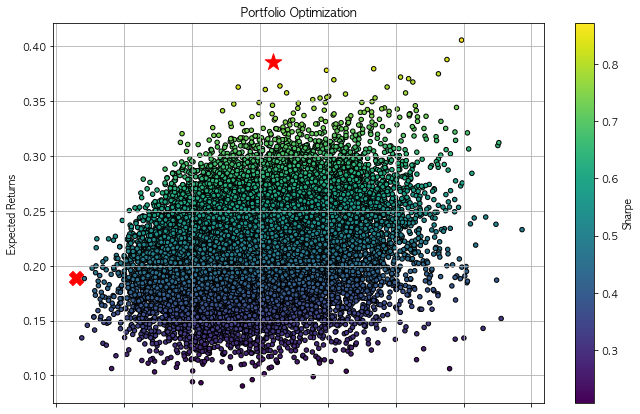

In [182]:
# max-sharpe portfolio와 min-risk portfolio 시각화
df.plot.scatter(x='Risk', y='Returns', c='Sharpe', cmap='viridis',
    edgecolors='k', figsize=(11,7), grid=True)

plt.scatter(x=max_sharpe['Risk'], y=max_sharpe['Returns'], c='r',      # max-sharpe *표시
    marker='*', s=300)

plt.scatter(x=min_risk['Risk'], y=min_risk['Returns'], c='r',          # min-risk X표시
    marker='X', s=200)

plt.title('Portfolio Optimization')
plt.xlabel('Risk')
plt.ylabel('Expected Returns')
plt.show()

## 5. 구매시점에서 포트폴리오별 백테스팅

해당시점부터 우리팀은 회사 업무로 너무 시달리고 있다. 너무 바빠졌다..ㅠ

제출을 더 늦춘다고 해도 도저히 시간이 나지 않아 백테스팅 하는 부분의 코드는 외부에서 많이 쓰이는 블로그의 소스코드를 가지고 왔다.

추후에 본선을 갈 기회가 생긴다면 싹 코드를 맞춤형으로 다시 짤 수 있을 것 같다. (본선으로 올려주십쇼!)

아래의 블로그의 코드를 통해 간단히 백테스팅만 해보기로 했다.
https://j-smallworld.tistory.com/15


원하는것은 22년 1월 1일에 투자를 했을 시 어떤 결과가 나오는지!
수익률을 확인해보고, 정말 위에서 정의한 최소 위험비중을 가진 포트폴리오와, 최고 샤프지수를 가진 포트폴리오에 성격이 맞게 추출이 되는지 검증을 해보는 시간을 가져보기로하자.

In [183]:
def get_stock_origintime(code):
    """
    Naver 금융 데이터 페이지를 크롤링하여 특정 종목의 상장일 획득
    :param code: 종목 코드
    :return: 종목코드 시작일자(origintime)
    """

    stock_data = []
    url = "https://fchart.stock.naver.com/sise.nhn?symbol={}&timeframe=day&count=1&requestType=0".format(code)
    html = requests.get(url).text
    soup = BeautifulSoup(html, "html.parser")
    origintime = soup.select_one("chartdata")['origintime']

    return origintime


# 주가 데이터 조회
def get_stock_data(code, from_date, to_date):
    """
    Naver 금융 데이터 페이지를 크롤링하여 주가 기록 조회
    :param code: 종목 코드
    :param from_date: 조회 시작일자
    :param to_date: 조회 종료일자
    :return: 해당 종목 코드의 일자, 시가, 고가, 저가, 종가, 거래량 데이터프레임
    """

    from_date = str(from_date)
    to_date = str(to_date)
    count = (datetime.today() - datetime.strptime(from_date, "%Y%m%d")).days + 1

    stock_data = []
    url = "https://fchart.stock.naver.com/sise.nhn?symbol={}&timeframe=day&count={}&requestType=0".format(code, count)
    html = requests.get(url).text
    soup = BeautifulSoup(html, "html.parser")
    data = soup.findAll('item')
    for row in data:
        daily_history = re.findall(r"[-+]?\d*\.\d+|\d+", str(row))
        if int(daily_history[0]) >= int(from_date) and int(daily_history[0]) <= int(to_date):
            daily_history[0] = datetime.strptime(daily_history[0], "%Y%m%d")
            daily_history[1] = float(daily_history[1])
            daily_history[2] = float(daily_history[2])
            daily_history[3] = float(daily_history[3])
            daily_history[4] = float(daily_history[4])
            daily_history[5] = float(daily_history[5])
            stock_data.append(daily_history)

    df = pd.DataFrame(stock_data, columns=['date', 'price', 'high', 'low', 'close', 'vol'])
    df.set_index(keys='date', inplace=True)
    return df


# 리밸런싱 하는 경우
def buy_stock(money, stock_price, last_stock_num, stock_rate):
    '''
    총 평가금액을 기준으로 설정 비율대로 리밸런싱 수행
    '''
    if stock_price == 0:
        return money, 0, 0

    stock_num = money * stock_rate // stock_price
    stock_money = stock_num * stock_price
    if last_stock_num < stock_num:
        fee = 0.00015 # 매수 수수료
    else:
        fee = 0.0023 # 매도 수수료
    buy_sell_fee = abs(last_stock_num - stock_num) * stock_price * fee
    while stock_num > 0 and money < (stock_money + buy_sell_fee):
        stock_num -= 1
        stock_money = stock_num * stock_price
        buy_sell_fee = abs(last_stock_num - stock_num) * stock_price * fee

    money -= (stock_money + buy_sell_fee)
    return money, stock_num, stock_money


# 월 적립만 하는 경우
def buy_stock_more(money, stock_price, last_stock_num, stock_rate):
    '''
    StockInfo.json 에서 interval_month 을 0으로 설정하는 경우
    기존 구매한 종목에 대해서는 리밸런싱 하지 않고
    추가 투자 금액만 가지고 비율대로 매수만 수행
    '''
    if stock_price == 0:
        return money, 0, 0

    stock_num = money * stock_rate // stock_price
    stock_money = stock_num * stock_price
    if last_stock_num < stock_num:
        fee = 0.00015 # 매수 수수료
    else:
        fee = 0.0023 # 매도 수수료
    buy_sell_fee = stock_num * stock_price * fee
    while stock_num > 0 and money < (stock_money + buy_sell_fee):
        stock_num -= 1
        stock_money = stock_num * stock_price
        buy_sell_fee = stock_num * stock_price * fee
    money -= (stock_money + buy_sell_fee)

    # 추가 매수한 만큼 더해준다
    stock_num = stock_num + last_stock_num
    stock_money = stock_num * stock_price

    return money, stock_num, stock_money


def get_ratio(names, prices, ratios):
    '''
    상장일이 모두 다르기 때문에 특정 기간 동안에는 일부 종목이 매수되지 않게 된다.
    이때는 상장 되어있는 종목으로만 구성하여 자산 비율을 재계산 한다.
    예) 4개의 종목을 각각 25%씩 구성 -> 백테스팅 기간 중 앞에 1년은 두 개 종목만 상장되어 있는 상태.
       상장된 두 개의 종목 구성 비율을 50%로 설정하여 현금을 최대한 투자에 사용하도록 함.

    현금이 남더라도 기존 설정 비율대로만 매수하도록 테스트 할 경우, 이 함수 맨 마지막 한 줄을 다음과 같이 변경하여 사용
    return new_ratios --> return ratios
    '''
    total_ratio = 0
    new_ratios = []
    for name in names:
        if prices[name] > 0:
            total_ratio += ratios[names.index(name)]
            new_ratios.append(ratios[names.index(name)])
        else:
            new_ratios.append(0)

    for i in range(len(new_ratios)):
        new_ratios[i] = round(new_ratios[i] * 1 / total_ratio, 2)

    return new_ratios


def back_test(money: int, interval: int, start_day: str, end_day: str, stock_list, monthly_amount: int, start_from_latest_stock: str):

    total_invest_money = money

    stock_code = []
    stock_name = []
    stock_ratio = []

    for sss in stock_list:
        stock_code.append(sss[0])
        stock_name.append(sss[1])
        stock_ratio.append(sss[2])

    if round(sum(stock_ratio)) > 1:
        print("ERROR!!! sum of ratio is over than 1.0")
        return

    first_date = 0
    for i in stock_code:
        org_time = get_stock_origintime(i)
        if start_from_latest_stock == "true":
            if first_date == 0 or first_date < org_time:
                first_date = org_time
        else:
            if first_date == 0 or first_date > org_time:
                first_date = org_time

    # 백테스팅 시작 날짜가 주식 리스트 중 가장 첫 상장일보다 빠른 경우 보정
    if first_date > start_day:
        start_day = first_date

    start_date = datetime.strptime(start_day, '%Y%m%d')  # 조회시작일

    cal_days = (datetime.strptime(end_day, "%Y%m%d") - start_date).days


    df = pd.DataFrame()

    for i in range(len(stock_code)):
        df_close = get_stock_data(stock_code[i], start_day, end_day)['close']
        df = pd.merge(df, df_close, how='outer', left_index=True, right_index=True)

    df.columns = stock_name
    df.fillna(0, inplace=True)
    #print(df)

    # 리밸런싱 날짜의 데이터만 new_df에 남깁니다.
    new_df = pd.DataFrame()
    while start_date <= df.index[-1]:
        temp_date = start_date
        while temp_date not in df.index and temp_date < df.index[-1]:
            temp_date += timedelta(days=1)  # 영업일이 아닐 경우 1일씩 증가.
        new_df = new_df.append(df.loc[temp_date])
        start_date += relativedelta(months=1)  # interval 개월씩 증가.


    # backtest_df = pd.DataFrame()  # 백테스트를 위한 데이터프레임
    backtest_index = []
    backtest_data = []

    #{ticker: False for ticker in tickers}
    etf_num = {etf: 0 for etf in stock_name} # 구매한 ETF 개수
    prices = {etf: 0 for etf in stock_name} # 현재가
    etf_money = {etf: 0 for etf in stock_name} # 평가금액


    date_idx = 0
    for each in new_df.index:

        rebalnace_day = True if (interval > 0 and date_idx%interval == 0) else False

        for stock in stock_name:
            prices[stock] = new_df[stock][each]
            # 리밸런싱 하는 달에는 총 금액 대비 비율 계산을 위해 보유 종목 매도 처리
            if rebalnace_day is True:
                money += etf_num[stock] * prices[stock]

        if date_idx > 0:
            money += monthly_amount
            # 총 투자금 대비 수익률 계산을 위해 투자금만 별도 관리
            total_invest_money += monthly_amount

        recal_ratio = get_ratio(stock_name, prices, stock_ratio)

        total = 0
        cal = 0

        for stock in stock_name:
            # 종목 매입
            try:
                if rebalnace_day is True:
                    # 리밸런싱 하는 경우, 전체 금액을 기준으로 투자 비율대로 매수
                    money, etf_num[stock], etf_money[stock] = buy_stock(money, prices[stock], etf_num[stock], recal_ratio[stock_name.index(stock)]/((1-cal) if cal < 1 else 1))
                else:
                    # 추가 매수만 하는 경우, 월 적립금을 기준으로 투자 비율대로 나누어 매수
                    money, etf_num[stock], etf_money[stock] = buy_stock_more(money, prices[stock], etf_num[stock], recal_ratio[stock_name.index(stock)]/((1-cal) if cal < 1 else 1))
            except Exception as e:
                print(e)

            if etf_num[stock] > 0:
                total += etf_money[stock]
                cal += recal_ratio[stock_name.index(stock)]

        total += money
        backtest_index.append(each)
        backtest_data.append(int(total)/total_invest_money)
        # backtest_df[each] = [int(total)]

        date_idx += 1


    # 행열을 바꿈
    backtest_df = pd.DataFrame(backtest_data, index=backtest_index, columns=['backtest'])
    # backtest_df = backtest_df.transpose()
    # backtest_df.columns = ['backtest', ]

    # 백테스트 결과 출력
    print("Total balance : {:>10}".format(str(int(total))))
    print("Investing Cash: {:>10}".format(str(total_invest_money)))
    print(backtest_df)

    # 최종 데이터 프레임, 3개의 지표와 백테스트 결과
    final_df = pd.concat([new_df, backtest_df], axis=1)

    # 시작점을 1로 통일함.
    for stock in stock_name:
        for pr in final_df[stock]:
            if pr > 0:
                final_df[stock] = final_df[stock] / pr
                break


   #final_df['backtest'] = final_df['backtest'] / total_invest_money

    return final_df

In [184]:
db1
db1['상장번호']


0     215200
1     028100
2     105740
3     067160
4     011390
5     002100
6     091590
7     143160
8     036480
9     009460
10    013360
11    000520
12    061970
13    198440
14    252500
Name: 상장번호, dtype: object

In [185]:
db1['회사명']



0     메가스터디교육
1        동아지질
2        디케이락
3      아프리카TV
4        부산산업
5          경농
6        남화토건
7        아이디스
8       대성미생물
9        한창제지
10       일성건설
11       삼일제약
12      엘비세미콘
13      고려시멘트
14      세화피앤씨
Name: 회사명, dtype: object

In [186]:
max_sharpe
ratio_list = []
for i in max_sharpe.columns:
    if i in list(db1['상장번호']):
        ratio_list.append(max_sharpe[i].values[0])

In [187]:
ratio_list

[0.15895594334525653,
 0.03595936946697741,
 0.12594160399968227,
 0.02184709340615615,
 0.003710520923522605,
 0.018088488182015822,
 0.007822292229034982,
 0.03092060528276434,
 0.14416342598219845,
 0.0396386911801243,
 0.029586511864037997,
 0.05224371681034944,
 0.16211694523126582,
 0.004208258761505456,
 0.1647965333351084]

정말 길고 긴 코드지만 우리가 원하는 데이터 input값만 넣어줌으로써 결과를 확인해보자
필요한 인풋값은
1. 주식 코드
2. 주식 이름
3. 비중

In [188]:
final_list = []
for i in range(len(db1)):
    fl = []
    fl.append(list(db1['상장번호'])[i])
    fl.append(list(db1['회사명'])[i])
    fl.append(ratio_list[i])

    final_list.append(fl)

In [189]:
final_list

[['215200', '메가스터디교육', 0.15895594334525653],
 ['028100', '동아지질', 0.03595936946697741],
 ['105740', '디케이락', 0.12594160399968227],
 ['067160', '아프리카TV', 0.02184709340615615],
 ['011390', '부산산업', 0.003710520923522605],
 ['002100', '경농', 0.018088488182015822],
 ['091590', '남화토건', 0.007822292229034982],
 ['143160', '아이디스', 0.03092060528276434],
 ['036480', '대성미생물', 0.14416342598219845],
 ['009460', '한창제지', 0.0396386911801243],
 ['013360', '일성건설', 0.029586511864037997],
 ['000520', '삼일제약', 0.05224371681034944],
 ['061970', '엘비세미콘', 0.16211694523126582],
 ['198440', '고려시멘트', 0.004208258761505456],
 ['252500', '세화피앤씨', 0.1647965333351084]]

## 6. 백테스트 결과
### 투자금 : 50,000,000 원
### 백테스팅 후 잔고 : 56,457,467 원
### 수익률 : 12.9%

In [190]:
back_test(50000000, 0, '20210101', '20211231',final_list, 0, 'false')

Total balance :   56457467
Investing Cash:   50000000
            backtest
2021-01-04  0.999852
2021-02-01  1.026800
2021-03-02  1.018883
2021-04-01  1.101727
2021-05-03  1.101068
2021-06-01  1.164802
2021-07-01  1.249498
2021-08-02  1.236477
2021-09-01  1.261475
2021-10-01  1.240262
2021-11-01  1.259119
2021-12-01  1.129149


,경농,고려시멘트,남화토건,대성미생물,동아지질,디케이락,메가스터디교육,부산산업,삼일제약,세화피앤씨,아이디스,아프리카TV,엘비세미콘,일성건설,한창제지,backtest
2021-01-04,1.000000,1.000000,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999852
2021-02-01,1.028689,1.045677,0.9400,1.201220,1.006061,0.963696,1.024600,1.224576,0.945946,1.028468,1.044803,1.019449,0.952218,1.186957,0.945833,1.026800
2021-03-02,1.061475,1.184339,0.9920,1.140244,0.990909,0.795380,1.303813,1.101695,0.997543,0.986025,0.982079,1.260940,0.846416,1.069565,0.937500,1.018883
2021-04-01,1.110656,1.223491,0.8280,1.216463,1.084848,0.848185,1.478475,1.110169,1.000000,1.036232,1.023297,1.283630,0.959044,1.239130,0.952083,1.101727
2021-05-03,1.258197,1.176183,0.8800,1.155488,1.112121,0.874587,1.384994,1.093220,0.942506,1.041408,0.989247,1.450567,0.921502,1.830435,1.020833,1.101068
2021-06-01,1.282787,1.239804,0.9240,1.210366,1.378788,0.834983,1.606396,1.262712,0.923833,1.068841,1.008961,1.583468,0.901024,2.191304,1.012500,1.164802
2021-07-01,1.385246,1.670473,0.9920,1.286585,1.354545,0.818482,1.690037,1.271186,0.939558,1.173913,0.965950,1.982172,0.904437,3.169565,1.162500,1.249498
2021-08-02,1.348361,1.468189,1.0400,1.155488,1.306061,0.752475,1.958180,1.262712,0.884521,1.045549,0.922939,2.139384,0.945392,2.991304,1.016667,1.236477
2021-09-01,1.221311,1.406199,0.9200,1.085366,1.272727,0.891089,1.901599,1.165254,0.894349,1.154244,0.897849,2.497569,0.883959,3.630435,0.939583,1.261475
2021-10-01,1.168033,1.192496,0.7880,0.993902,1.157576,0.848185,1.773678,1.152542,0.799017,1.024845,0.856631,2.340357,0.846416,5.739130,0.866667,1.240262


2018년 ~ 2020년 의 각각 연도별 데이터를 k-mean 클러스터링 한 뒤, 수익률이 좋았던 클러스터를 교집합하고, fundamental 지표로 추린 후, 몬테카를로 시뮬레이션을 통해 포트폴리오의 최적의 예산 분배 비율도 구하였다.

이 모든 과정을 거친 종목들을 2021년 1년동안 투자하였다고 가정했을 때, 무려 12.9% 의 수익률을 기록하였다.


# 개선사항
1. 마지막 단계에서의 백테스팅 하는 코드를 직접 구현하는 방식 -> 수익률 뿐만 아니라 다양한 지표까지 확인하는 작업
2. 여러 기간에 맞춰 테스트를 해보고 비교하는 작업 -> 위의 단계에서는 2018~2020년 데이터를 2021년 1년동안 투자하는 관점으로 테스트를 했지만, 다양한 기간에서 다양하게 테스트하고 비교하는 작업이 있으면 더 좋았을 듯 하다
3. 제공된 데이터를 활용하여 조금 더 디테일한 정보를 융합하여 금융 상품을 만들 수 있었을것같은데 아쉬움이 있다.

# 이번 데이콘 경진대회 첫 출전에서 느낀 점
1. K-Mean과정에서 군집화를 한 이후 종목을 추리는 과정에서의 다양한 방법
    ex) 조금 더 퀀트적인 지표 MFI, II, Stochastic, Bollinger Band(Percnet) 등 다양한 시도를 기존에 많이 해보았지만 여러 여건상 테스트 할 기회가 없었어서 아쉬움이 남는다.
2. 제공된 데이터를 활용하여 조금 더 디테일한 정보를 융합하여 금융 상품을 만들 수 있었을것같은데 아쉬움이 있다.
3. 상당히 좋은 기회였다. 기존에 주식 관련 사이드 프로젝트를 하고 있어 더 아쉬움이 남기도 하다(이놈의 회사 업무 너무 바쁘다..!). 또한 다양한 ML알고리즘을 공부하고 테스트 해볼 수 있어서 감사하다.
